In [1]:
# importing file module
from google.colab import files

In [2]:
# uploading files
uploaded = files.upload()

Saving AB_NYC_2019.csv to AB_NYC_2019.csv


In [3]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [34]:
#loading dataset
df = pd.read_csv('AB_NYC_2019.csv')
print(df.shape)
df.head()

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Looking at the price variable

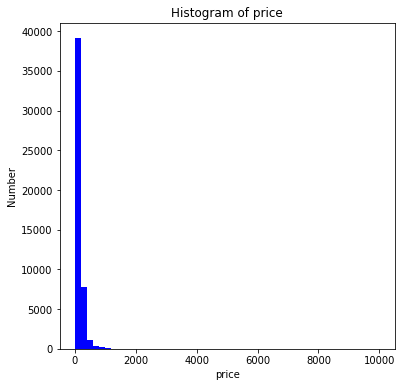

In [5]:
fig = plt.figure(figsize=(6,6))
ax= fig.gca()
df['price'].plot.hist(ax = ax, bins = 50, color = 'blue')
ax.set_title('Histogram of ' + 'price')
ax.set_xlabel('price')
ax.set_ylabel('Number')
plt.show()

**Question 1**
Find a feature with missing values. How many missing values does it have?

In [61]:
df_selected = df[['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                  'calculated_host_listings_count', 'availability_365']]
df_selected.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

**Question 2**
What's the median (50% percentile) for variable 'minimum_nights'?

In [62]:
df_selected['minimum_nights'].median()

3.0

In [63]:

n = len(df_selected)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
# shuffling the dataset
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_shuffled = df_selected.iloc[idx]
# partioning dataset to train, valiadtion and test set
df_train = df_shuffled.iloc[idx[:n_train]]
df_val = df_shuffled.iloc[idx[n_train:n_train+n_val]]
df_test = df_shuffled.iloc[idx[n_train+n_val:]]

In [64]:
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

In [65]:
del df_train['price']
del df_val['price']
del df_test['price']

**Question3**

In [66]:
#filling missing values with mean
def fill_with_mean(df):
    X = df.fillna(df_train.mean()).values
    return X
X_train_mean = fill_with_mean(df_train)

In [67]:
#filling missing values with zero
def fill_with_zero(df):
    X = df.fillna(0).values
    return X
X_train_zero = fill_with_zero(df_train)

In [68]:
# linear regression function
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [69]:
#linear regression when filling missing values with zero
w0, w = train_linear_regression(X_train_zero, y_train) #training regression model
print(w0, w)
X_val_zero = fill_with_zero(df_val) #prepare validation set
y_pred_zero = w0 + X_val_zero.dot(w)

-423.2511307961826 [ 1.38204324e+00 -5.02546695e+00 -1.16710488e-03 -6.38929127e-04
 -2.27581034e-03  1.31471897e-03  6.42652582e-04]


In [70]:
#linear regression when filling missing values with mean
w0, w = train_linear_regression(X_train_mean, y_train)
print(w0, w)
X_val_mean = fill_with_mean(df_val) #prepare validation set
y_pred_mean = w0 + X_val_mean.dot(w)

-426.1303365319303 [ 1.38370544e+00 -5.06333633e+00 -1.09249727e-03 -8.71205486e-04
  1.07547226e-02  1.29760380e-03  6.31952184e-04]


In [71]:
#function for RMSE
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [72]:
#RMSE when filling missing values with zero
rmse(y_val, y_pred_zero)

0.6455583878950478

In [73]:
#RMSE when filling missing values with mean
rmse(y_val, y_pred_mean)

0.6456186726039147

**Question 4**

In [74]:
# regularization function
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [75]:
#linear regression with regularization when filling missing values with zero
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
  print('r='+str(r))
  w0, w = train_linear_regression_reg(X_train_zero, y_train, r=r) #training regression model
  y_pred_zero = w0 + X_val_zero.dot(w)
  answer = round(rmse(y_val, y_pred_zero), 2)
  print(answer)

r=0
0.65
r=1e-06
0.65
r=0.0001
0.65
r=0.001
0.65
r=0.01
0.66
r=0.1
0.68
r=1
0.68
r=5
0.68
r=10
0.68


**Question 5**

In [76]:
# creating empty list
rmse_scores = []

In [77]:
for number in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
  n = len(df_selected)

  n_val = int(n * 0.2)
  n_test = int(n * 0.2)
  n_train = n - n_val - n_test
  # shuffling the dataset
  idx = np.arange(n)
  np.random.seed(number)
  np.random.shuffle(idx)
  # partioning dataset to train, valiadtion and test set
  df_train = df_selected.iloc[idx[:n_train]]
  df_val = df_selected.iloc[idx[n_train:n_train+n_val]]
  df_test = df_selected.iloc[idx[n_train+n_val:]]
  #log transformation
  y_train_orig = df_train.price.values
  y_val_orig = df_val.price.values
  y_test_orig = df_test.price.values

  y_train = np.log1p(y_train_orig)
  y_val = np.log1p(y_val_orig)
  y_test = np.log1p(y_test_orig)
  #removing target variable
  del df_train['price']
  del df_val['price']
  del df_test['price']
  #filling missing values with zero
  X_train_zero = fill_with_zero(df_train)
  #linear regression when filling missing values with zero
  w0, w = train_linear_regression(X_train_zero, y_train) #training regression model
  X_val_zero = fill_with_zero(df_val) #prepare validation set
  y_pred_zero = w0 + X_val_zero.dot(w)
  #RMSE when filling missing values with zero
  answer = rmse(y_val, y_pred_zero)
  rmse_scores.append(answer)

In [78]:
print(rmse_scores)

[0.6549779961157263, 0.646252368578719, 0.6476558177163445, 0.6375145071233626, 0.6445809083551755, 0.6305809996077186, 0.6297851917617103, 0.6506184267164312, 0.6489780353432693, 0.6437565168302604]


In [79]:
# std of all scores
std = np.std(rmse_scores)
result = round(std, 3)
print(result)

0.008


**Question 6**

In [83]:
# shuffling the dataset
n = len(df_selected)
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)
# partioning dataset to train, valiadtion and test set
df_train = df_selected.iloc[idx[:n_train]]
df_val = df_selected.iloc[idx[n_train:n_train+n_val]]
df_test = df_selected.iloc[idx[n_train+n_val:]]
#combining train and validation set
X_frames = [df_train, df_val]
train_val = pd.concat(X_frames) #combining features
#getting y values
y_test_orig = df_test.price.values
y_train_val_orig = train_val.price.values
#log transformation
y_train_val = np.log1p(y_train_val_orig)
y_test = np.log1p(y_test_orig)
#removing price from dataset
del train_val['price']
del df_test['price']
#filling missing values with zero
X_train_zero = fill_with_zero(train_val)
#linear regression when filling missing values with zero
w0, w = train_linear_regression_reg(X_train_zero, y_train_val, r=0.001) #training regression model
X_test_zero = fill_with_zero(df_test) #prepare test set
y_pred_zero = w0 + X_test_zero.dot(w)
#RMSE when filling missing values with zero
answer = rmse(y_test, y_pred_zero)
print(answer)

0.6452771348554612
